# BBM409 : Introduction to Machine Learning Lab. Assignment 1

#### Pre-Note
- Graphs and Tables will be updated on new run.

#### PROBLEM DEFINITION :

    
In this assignment, we were asked to understand the KNN classification and KNN regression algorithms and perform a basic experiment with appropriate datasets.
    
In the first part of the experiment, we classified the various types of glass given to us using the KNN algorithm. In this dataset where glass types were given, there were element amounts in the glasses as attributes of each data. We tried to classify the elements according to the amount of content and tried to reach the most accurate results with the predictions with the highest element content similarity. 

In the second part of the experiment, we tried to estimate the strength rate values of the concrete types given to us by using the KNN algorithm. In this estimation process, we estimated the strength rate value of the relevant data by averaging the closest data according to the similarity of the content amounts.


In [1]:
!pip install -r requirements.txt

You should consider upgrading via the 'c:\users\berkay\desktop\workspace\bbm409\assig_1\venv\scripts\python.exe -m pip install --upgrade pip' command.


First, we need to install the packages specified in the *requirements.txt* file. 

## Imports

We imported the necessary packages and modules.

In [2]:
from math import sqrt
import numpy as np
from tqdm import tqdm
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import itertools
from time import time

In [3]:
%matplotlib inline

### Graph Drawer Method

Method that draws line graph according to different **accuracy** and **mae** values with respect to different **k** values.

In [4]:
def plot_k_values_and_accuracies(title1, title2, arr1, arr2, fontSize, isAcc=True):
    x = np.array(["1", "3", "5", "7", "9"])
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace=0.4)
    plt.plot(x, arr1, marker='o')

    plt.title(title1, fontdict=fontSize)
    plt.xlabel("K values")

    plt.ylabel("Accuracies" if isAcc else "Mean MAE")

    plt.subplot(1, 2, 2)
    plt.plot(x, arr2, marker='o')

    plt.title(title2, fontdict=fontSize)
    plt.xlabel("K values")
    plt.ylabel("Accuracies" if isAcc else "Mean MAE")

    plt.show()

### Euclidean Distance Method

Euclidian distance function that compares each attribute of the data in each row and calculates their distance from each other in numerical dimension. We subtracted the values ​​in each column of the two selected data, squared them, and summed up all of this result. Finally, by taking the square root of the entire total value, we determined the distance of the two data from each other. 

In [5]:
def euclidean_distance(first_row, second_row):
    if len(first_row) != len(second_row):
        raise Exception("Two rows must have the same dimension!")

    total = 0
    for index in range(len(first_row)):
        diff_square = (first_row[index] - second_row[index]) ** 2
        total += diff_square
    return sqrt(total)

### Accuracy Calculator Method

Function that calculates the total accuracy score by considering the equality of the predicted class values with the real class values. Finally, multiply the total accuracy rate by one hundred to get a percentage value. 

In [6]:
def accuracy_score(predicted, labels):
    predicted = np.array(predicted)
    labels = np.array(labels)

    # Comparison between predictions and the test labels.
    accuracy = (predicted == labels).sum() / len(predicted)
    # print(accuracy*100)
    return accuracy * 100

### Mean Absolute Error Calculator Method

The mean absolute error value is the sum of the differences between the actual strength rate values and the estimated value, divided by the total number of data, and the absolute value of the result. 

In [7]:
def mean_absolute_error(predicted, labels):
    predicted = np.array(predicted)
    labels = np.array(labels)


    mae = np.absolute(labels - predicted).sum() / len(predicted)
    return mae

### Min-Max Normalization Method

Method that applying min-max normalization column wise using only numpy functions

In [8]:
def min_max_normalization(data):
    # max_bucket = [-1000000000 for i in range(len(data[0]))]

    # working on temp data
    temp_data = data.copy()

    length = len(temp_data[0])

    # scaling each attribute of the data
    for i in range(length):
        col_data = temp_data[:, i]
        _max = np.max(col_data)
        _min = np.min(col_data)

        # applying min-max normalization
        col_data = (col_data - _min) / (_max - _min)

        # replace data
        temp_data[:, i] = col_data

    return temp_data


### k-fold Cross Validation Splitter Method

Method that splits given data into **k** parts that have equal sizes. 

In [9]:
def k_fold_cross_validation_split(X, k=5):
    # takes numpy array as an argument
    # shuffle
    np.random.shuffle(X)

    splitted_data = []
    data_partition_num = len(X) / k

    for i in range(k):
        start = int(i * data_partition_num)
        end = int((i + 1) * data_partition_num)

        test_set = X[start:end, :]
        train_set = np.concatenate((X[0:start, :], X[end:, :]), axis=0)

        splitted_data.append(np.array([train_set, test_set], dtype=object))

    return np.array(splitted_data)


### Method That Performs Cross Validation(runs all possible train set combinations)

This method performs **train** and **test** process for all possible train set-test set splits.

Takes one of **knn instances** as a parameter and calls relevant knn's fit and predict methods. On the other hand, decides whether calculate accuracy or mae by consider **classification** boolean parameter which is True for **Classification** case and False for **Regression** case.   

In [10]:
def cross_validation(splitted_data, knn, normalize, classification):
    accuracies = []
    mae_values = []

    for data in splitted_data:
        sample_train = data[0]
        sample_test = data[1]

        # print(sample_train.shape)
        # print(sample_test.shape)

        # train and test sets
        X_train = sample_train[:, :-1]
        y_train = sample_train[:, -1]

        X_test = sample_test[:, :-1]
        y_test = sample_test[:, -1]

        if normalize:
            """
                Applying min-max normalization to data

                Applying separately to avoid data leakage
            """
            X_train = min_max_normalization(X_train)
            X_test = min_max_normalization(X_test)

        # fitting data
        knn.fit(X_train, y_train)

        # prediction part
        predictions = knn.predict(X_test)

        # print(knn.y_train)
        # print(predictions)
        # print(y_test)

        if classification:
            # calculate accuracy
            accuracy = accuracy_score(predictions, y_test)
            accuracies.append(accuracy)
        else:
            mae = mean_absolute_error(predictions, y_test)
            mae_values.append(mae)

    if classification:
        accuracies = np.array(accuracies)
        return accuracies, np.mean(accuracies)
    else:
        return mae_values, np.mean(mae_values)


### KNN Base Class

KNN parent class for **classification** which includes common method in **weighted** and **standard** KNN-Classifier

In [11]:
class KnnBase:

    # setting k value of KNN algorithm
    def __init__(self, k=3):
        self.k = k

    # setting attribute and class data
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # majority voting function
    def vote(self, neighbours, frequence_array):
        raise NotImplementedError("Each class must implement their own voting function !")

    def predict(self, X):
        predicted_classes = [self.predict_helper(row) for row in X]
        return predicted_classes

    def predict_helper(self, x):
        raise NotImplementedError("Each class must implement their own predict_helper function !")


### KNN Classification Class Without Weight Values

KNN child class of KNNBase for **non-weighted** classification which implemented own methods

In [12]:
class KNN(KnnBase):

    # setting k value of KNN algorithm
    def __init__(self, k=3):
        super().__init__(k)

    # majority voting function
    def vote(self, neighbours, frequence_array=None):
        distances = []
        classes = []
        indexes = []

        for neighbour in neighbours:
            index = neighbour[1]  # neighbour[1] : index of related data's row
            # recall --> [dist, index_of_neighbour]

            _class = self.y_train[index]  # _ class : corresponding data in the Class set
            _distance = neighbour[0]  # neighbour[0] : distance of related data

            # save all information in various lists
            distances.append(_distance)
            classes.append(_class)
            indexes.append(index)

        # print("-----voting part-----")
        counted = list(Counter(classes).items())  # numerical grouping by class of each data
        # print(classes)
        # print(counted)
        # print("distances: ", distances)

        most_common = counted[0]  # find the most repetitive class
        class_numbers = [i[1] for i in counted]  # store the number of repetitions of classes
        # print(class_numbers)

        if class_numbers.count(most_common[0]) > 1:  # if the most common class has more than one sample

            # x = input("tie found, press any key to continue")

            # that means we have a tie situation..
            classes_of_duplicate_occurrences = []
            for cnt in counted:
                if cnt[1] == most_common[1]:
                    # the one that we are looking for
                    classes_of_duplicate_occurrences.append(
                        cnt[0])  # find the classes of the data that provide the tie situation

            # print(classes_of_duplicate_occurrences)

            # breaking tie part
            new_distances = [[] for i in range(int(max(classes_of_duplicate_occurrences)) + 1)]

            for _class in classes_of_duplicate_occurrences:
                for __index, __class in enumerate(classes):
                    if _class == __class:
                        # access distance of neighbour from the array which is created above
                        indiv_distance = distances[__index]

                        # store distances to calculate sums later and decide nearest neighbour
                        new_distances[int(_class)].append(indiv_distance)

            # print(new_distances)

            empty_list_indices = [i for i in range(len(new_distances)) if len(new_distances[i]) == 0]

            for index, new_distance in enumerate(new_distances):
                new_distances[index] = sum(new_distance)

            new_distances = np.array(new_distances)
            # print(new_distances)

            sorted_indices = np.argsort(new_distances)
            # print(sorted_indices)

            # print("empty part")
            # print(empty_list_indices)

            will_be_deleted_indices = []
            for index in empty_list_indices:
                for i, _index in enumerate(sorted_indices):
                    if index == _index:
                        will_be_deleted_indices.append(i)

            sorted_indices = np.delete(sorted_indices, will_be_deleted_indices)
            # print(sorted_indices)

            predicted_class = int(sorted_indices[0])
            # print(predicted_class)
        else:
            # no tie select most common as nearest neighbour
            predicted_class = int(most_common[0])

        return predicted_class

    def predict_helper(self, x):
        """
        [
            [dist, index_of_neighbour],
            [another_dist, index_of_another_neighbour],
            ...
        ]
        """

        # distance calculation
        distances = [[euclidean_distance(x, self.X_train[i]), i] for i in range(len(self.X_train))]

        # sorting to find nearest neighbour
        # print(distances)
        sorted_array = sorted(distances, key=lambda x: x[0])
        # print(sorted_array)

        # print("Asked data: ", x.astype(int))
        # print("Nearest Neighbours:")
        for m in range(self.k):
            index = sorted_array[m][1]
            # print(self.X_train[index], ", class: " ,self.y_train[index])

        predicted = self.vote(sorted_array[:self.k])
        return predicted

### KNN Classification Class With Weights

KNN child class of KnnBase for **classification** with weight values and also implements own methods.

In [13]:
class WeightedKNN(KnnBase):

    # setting k value of KNN algorithm
    def __init__(self, k=3):
        super().__init__(k)

    # majority voting function
    def vote(self, neighbours, frequence_array):
        distances = []
        classes = []
        indexes = []
        weights = []

        for neighbour in neighbours:
            _index = neighbour[1]  # neighbour[1] : index of related data's row
            # recall --> [dist, index_of_neighbour]

            _class = self.y_train[_index]  # _ class : corresponding data in the Class set
            _distance = neighbour[0]  # neighbour[0] : distance of related data
            _weight = 1 if _distance == 0 else (1 / _distance)

            # save all information in various lists
            distances.append(_distance)
            classes.append(_class)
            indexes.append(_index)
            weights.append(_weight)

        # just for convention
        counted = frequence_array

        # print("-----voting part-----")

        # old code
        # counted = list(Counter(classes).items())

        # print(classes)
        # print(counted)
        # print("distances: ", distances)

        most_common = counted[0]  # find the most repetitive class
        class_numbers = [i[1] for i in counted]  # store the number of repetitions of classes
        # print(class_numbers)

        if class_numbers.count(most_common[0]) > 1:  # if the most common class has more than one sample

            # x = input("tie found, press any key to continue")

            # that means we have a tie situation
            classes_of_duplicate_occurrences = []
            for cnt in counted:
                if cnt[1] == most_common[1]:
                    # the one that we are looking for
                    classes_of_duplicate_occurrences.append(cnt[0])

            # print(classes_of_duplicate_occurrences)

            # breaking tie part
            new_distances = [[] for i in range(int(max(classes_of_duplicate_occurrences)) + 1)]

            for _class in classes_of_duplicate_occurrences:
                for __index, __class in enumerate(classes):
                    if _class == __class:
                        # access distance of neighbour from the array which is created above
                        indiv_distance = distances[__index]

                        # store distances to calculate sums later and decide nearest neighbour
                        new_distances[int(_class)].append(indiv_distance)

            # print(new_distances)

            empty_list_indices = [i for i in range(len(new_distances)) if len(new_distances[i]) == 0]

            for index, new_distance in enumerate(new_distances):
                new_distances[index] = sum(new_distance)

            new_distances = np.array(new_distances)
            # print(new_distances)

            sorted_indices = np.argsort(new_distances)
            # print(sorted_indices)

            # print("empty part")
            # print(empty_list_indices)

            will_be_deleted_indices = []
            for index in empty_list_indices:
                for i, _index in enumerate(sorted_indices):
                    if index == _index:
                        will_be_deleted_indices.append(i)

            sorted_indices = np.delete(sorted_indices, will_be_deleted_indices)
            # print(sorted_indices)

            predicted_class = int(sorted_indices[0])
            # print(predicted_class)
        else:
            # no tie select most common as nearest neighbour
            predicted_class = int(most_common[0])

        return predicted_class

    def predict_helper(self, x):
        """
        [
            [dist, index_of_neighbour],
            [another_dist, index_of_another_neighbour],
            ...
        ]
        """

        # distance calculation
        distances = [[euclidean_distance(x, self.X_train[i]), i] for i in range(len(self.X_train))]

        # sorting to find nearest neighbour
        # print(distances)
        sorted_array = sorted(distances, key=lambda x: x[0])
        # print(sorted_array)

        # print("Asked data: ", x.astype(int))
        # print("Nearest Neighbours:")
        for m in range(self.k):
            index = sorted_array[m][1]
            # print(self.X_train[index], ", class: " ,self.y_train[index])

        # finding maximum class number to decide weight_dict size
        maximum_class = int(np.max([self.y_train[i[1]] for i in sorted_array[:self.k]]))

        weight_dict = {(i + 1): 0 for i in range(maximum_class + 1)}

        for _tuple in range(self.k):
            neighb_val = self.y_train[sorted_array[_tuple][1]]
            # print(sorted_array[_tuple][0])
            if not sorted_array[_tuple][0] == 0:
                weight_dict[neighb_val] += (1 / sorted_array[_tuple][0])
            else:
                # if distance value equals to 0, weight value becomes 1 to avoid zero division error
                weight_dict[neighb_val] += 1

        # equivalent of Counter() method output from collections which has used on basic KNN
        """
        frequence_array = [
            (class1, weight1), 
            (class2, weight2),
            (..., ...),
            ...
        ]
        """
        frequence_array = [(_class, weight_dict[_class]) for _class in weight_dict.keys()]
        frequence_array = sorted(frequence_array, key=lambda x: x[1], reverse=True)

        # print(frequence_array)

        # print(sorted_array[:self.k])
        predicted = self.vote(sorted_array[:self.k], frequence_array)
        return predicted


### KNN Regression Base Class

KNN base class for **regression** part, includes common methods for weighted and non-weighted regression. The rest will be implemented by child classes and specified with **NotImplementedError** 

In [14]:
class KNNRegressionBase:

    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def regression(self, neighbours):
        raise NotImplementedError("Each class must implement their regression function !")

    def predict(self, X):
        predicted_classes = [self.predict_helper(row) for row in X]
        return predicted_classes

    def predict_helper(self, x):
        """
        [
            [dist, index_of_neighbour],
            [another_dist, index_of_another_neighbour],
            ...
        ]
        """

        # distance calculation
        distances = [[euclidean_distance(x, self.X_train[i]), i] for i in range(len(self.X_train))]

        # sorting to find nearest neighbour
        # print(distances)
        sorted_array = sorted(distances, key=lambda x: x[0])
        # print(sorted_array)

        # print("Asked data: ", x.astype(int))
        # print("Nearest Neighbours:")
        for m in range(self.k):
            index = sorted_array[m][1]
            # print(self.X_train[index], ", class: " ,self.y_train[index])

        predicted = self.regression(sorted_array[:self.k])
        return predicted

### KNN Regression Class Without Weight Values

KNN child class of *KNNRegressionBase* for regression part without weight values. Also implemented own **regression** method.

In [15]:
class KNNRegression(KNNRegressionBase):

    def __init__(self, k=3):
        super().__init__(k)

    def regression(self, neighbours):
        values = [self.y_train[neighbour[1]] for neighbour in neighbours]
        return np.mean(values)


### KNN Regression Class With Weight Values

KNN child class of *KNNRegressionBase* for regression part with weight values and also implemented own **regression** method.

In [16]:
class WeightedKNNRegression(KNNRegressionBase):

    def __init__(self, k=3):
        super().__init__(k)

    def regression(self, neighbours):
        values = np.array([self.y_train[neighbour[1]] for neighbour in neighbours])
        weights = np.array([(1 / neighbour[0]) if neighbour[0] != 0 else 1 for neighbour in neighbours])

        return ((values * weights).sum()) / weights.sum()


### Test Method That Performs Several Tests Which Are All Possible Scenarios

General test method that performs several test according to all possibilities specified in assignment pdf file. In addition; reading data from '.csv' file and convert pandas DataFrame to numpy array, splitting 5 different train-test sets according to given value 5, creating relevant arrays for drawing **accuracy** and **error** graphs, etc. done in this method. 

In [17]:
def generalTest():

    start = time()
    
    # classification part
    classification_data = pd.read_csv("glass.csv")
    classification_data = np.array(classification_data)

    # 5 fold cross validation
    splitted = k_fold_cross_validation_split(classification_data, 5)

    # regression part
    regression_data = pd.read_csv("Concrete_Data_Yeh.csv")
    regression_data = np.array(regression_data)

    # 5 fold cross validation
    regression_splitted = k_fold_cross_validation_split(regression_data, 5)

    k_list_withWeight = []
    k_list_withoutWeight = []
    k_list_withWeight_nonNormalized = []
    k_list_withoutWeight_nonNormalized = []
    k_list_withWeight_MAE = []
    k_list_withoutWeight_MAE = []
    k_list_withWeight_nonNormalized_MAE = []
    k_list_withoutWeight_nonNormalized_MAE = []
    
    table_data_classification = [[] for i in range(5)]
    table_data_regression = [[] for i in range(5)]
    
    for i in range(1, 6):
        k_val = (2 * i) - 1

        for bool in [True, False]:
            text = "With" if bool else "Without"
            separator = "*********************************" if bool else "*****************"
            print(separator)
            print(f"{text} Normalization, k={k_val}")

            print("-----Classification Part-----")
            knn = KNN(k=k_val)
            knn1 = WeightedKNN(k=k_val)

            accuracies, mean_acc = cross_validation(splitted, knn, normalize=bool, classification=True)
            accuracies1, mean_acc1 = cross_validation(splitted, knn1, normalize=bool, classification=True)
            
            # print accuracies for different train-test splits
            print("Distance based accuracies: {}, mean: {}".format(accuracies, mean_acc))
            print("Weighted accuracies: {}, mean: {}".format(accuracies1, mean_acc1))

            print("-----Regression Part-----")
            knn2 = KNNRegression(k=k_val)
            knn3 = WeightedKNNRegression(k=k_val)

            mae_values, mean_mae = cross_validation(regression_splitted, knn2, normalize=bool, classification=False)
            mae_values1, mean_mae1 = cross_validation(regression_splitted, knn3, normalize=bool,
                                                      classification=False)

            # print mae values for different train-test splits
            print("Mae values: {}, mean: {}".format(mae_values, mean_mae))
            print("Weighted Mae values: {}, mean: {}".format(mae_values1, mean_mae1))

            if bool:
                table_data_classification[i-1] = [accuracies1, accuracies]
                table_data_regression[i-1] = [mae_values1, mae_values]
                
                k_list_withoutWeight.append(mean_acc)
                k_list_withWeight.append(mean_acc1)
                k_list_withoutWeight_MAE.append(mean_mae)
                k_list_withWeight_MAE.append(mean_mae1)
            else:
                table_data_classification[i-1].extend([accuracies1, accuracies])
                table_data_regression[i-1].extend([mae_values1, mae_values])
                
                k_list_withoutWeight_nonNormalized.append(mean_acc)
                k_list_withWeight_nonNormalized.append(mean_acc1)
                k_list_withoutWeight_nonNormalized_MAE.append(mean_mae)
                k_list_withWeight_nonNormalized_MAE.append(mean_mae1)
    
    print("\nTOOK {} SECONDS.".format(time()-start))
    # returning relevant arrays for drawing graphs 
    return [
        k_list_withoutWeight, k_list_withWeight, 
        k_list_withoutWeight_nonNormalized, k_list_withWeight_nonNormalized, 
        k_list_withoutWeight_MAE, k_list_withWeight_MAE, 
        k_list_withWeight_nonNormalized_MAE, k_list_withoutWeight_nonNormalized_MAE,
        table_data_classification, table_data_regression
    ]
    
    

### Display Method For Calling Plot Method For Every Graph

In [18]:
def display(k_list_withoutWeight, k_list_withWeight, 
    k_list_withoutWeight_nonNormalized, k_list_withWeight_nonNormalized, 
    k_list_withoutWeight_MAE, k_list_withWeight_MAE, 
    k_list_withoutWeight_nonNormalized_MAE, k_list_withWeight_nonNormalized_MAE):
    
   
    
    # plotting graphs
    plot_k_values_and_accuracies("KNN without weights", "KNN with weights", k_list_withoutWeight, k_list_withWeight,
                                 {'size': 12})
    plot_k_values_and_accuracies("KNN without weights (non normalized)", "KNN with weights (non normalized)",
                                 k_list_withoutWeight_nonNormalized, k_list_withWeight_nonNormalized, {'size': 9})
    plot_k_values_and_accuracies("KNN Regression without weights", "KNN Regression with weights",
                                 k_list_withoutWeight_MAE, k_list_withWeight_MAE, {'size': 10}, isAcc=False)
    plot_k_values_and_accuracies("KNN Regression without weights (non normalized)",
                                 "KNN Regression with weights (non normalized)",
                                 k_list_withoutWeight_nonNormalized_MAE, k_list_withWeight_nonNormalized_MAE,
                                 {'size': 7}, isAcc=False)

### Obtaining Data Needed For Graphs and Running Main Method with General Test Method

In [19]:
 # relevant data
arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8, table_cls, table_reg = generalTest()
# [array([40.47619048, 44.18604651, 51.1627907 , 62.79069767, 79.06976744])

*********************************
With Normalization, k=1
-----Classification Part-----
Distance based accuracies: [64.28571429 58.13953488 44.18604651 46.51162791 72.09302326], mean: 57.04318936877077
Weighted accuracies: [64.28571429 58.13953488 44.18604651 46.51162791 72.09302326], mean: 57.04318936877077
-----Regression Part-----
Mae values: [6.503883495145632, 6.675436893203883, 6.458058252427185, 7.0697572815533976, 6.523058252427185], mean: 6.646038834951456
Weighted Mae values: [6.503883495145632, 6.675436893203883, 6.458058252427185, 7.0697572815533976, 6.523058252427185], mean: 6.646038834951456
*****************
Without Normalization, k=1
-----Classification Part-----
Distance based accuracies: [78.57142857 62.79069767 67.44186047 60.46511628 72.09302326], mean: 68.27242524916943
Weighted accuracies: [78.57142857 62.79069767 67.44186047 60.46511628 72.09302326], mean: 68.27242524916943
-----Regression Part-----
Mae values: [5.937621359223302, 6.557961165048544, 5.93990291262

### Calling Method Called Display For Graphs

In this part, we can see how average **accuracy** and **mae** values have changed according to different k values on graphs.

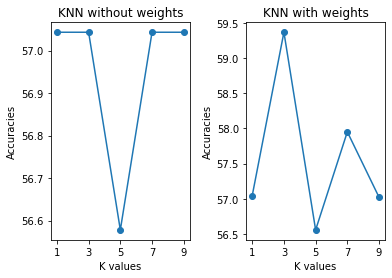

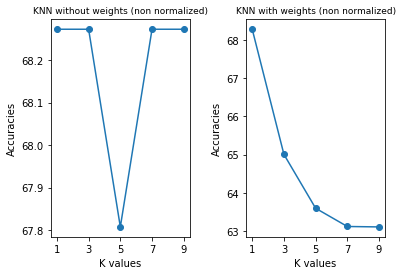

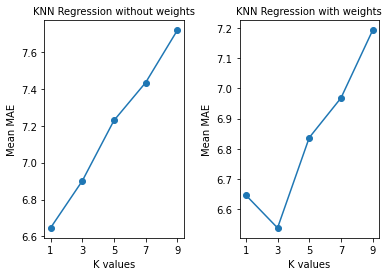

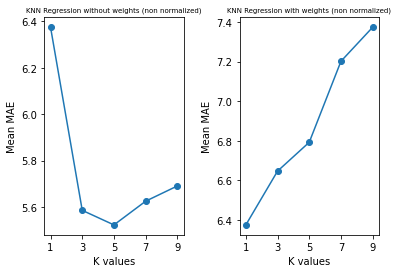

In [20]:
display(arr1, arr2, arr3, arr4, arr5, arr6, arr7, arr8)

##### Table Structure Order

'k=1\nNormalized\nWeighted', 
'k=1\nNormalized\nNon-Weighted', 
'k=1\nNon-Normalized\nWeighted', 
'k=1\nNon-Normalized\nNon-Weighted',

'k=3\nNormalized\nWeighted', 
'k=3\nNormalized\nNon-Weighted',
'k=3\nNon-Normalized\nWeighted', 
'k=3\nNon-Normalized\nNon-Weighted', 

'k=5\nNormalized\nWeighted',
'k=5\nNormalized\nNon-Weighted', 
'k=5\nNon-Normalized\nWeighted', 
'k=5\nNon-Normalized\nNon-Weighted', 

'k=7\nNormalized\nWeighted',
'k=7\nNormalized\nNon-Weighted',
'k=7\nNon-Normalized\nWeighted', 
'k=7\nNon-Normalized\nNon-Weighted',

'k=9\nNormalized\nWeighted',
'k=9\nNormalized\nNon-Weighted',
'k=9\nNon-Normalized\nWeighted', 
'k=9\nNon-Normalized\nNon-Weighted

#### Editing Raw Result Data for Table Structure

In [21]:
# classification
def create_table_data(raw_data):
    # k_list_withWeight, k_list_withoutWeight, k_list_withWeight_nonNormalized, k_list_withoutWeight_nonNormalized

    #arr2, arr1, arr4, arr3 = np.concatenate(([arr2],[arr1],[arr4],[arr3]), axis=0)
    refined_data = []
    raw_data = np.array(raw_data)
    for index, row in enumerate(raw_data):
        new_row = row.T
        refined_data.append(new_row)

        averages = [[np.mean(new_row[:,k]) for k in range(new_row.shape[1])]]

        temp = refined_data[index]

        temp = np.concatenate((temp,np.array(averages)), axis=0)
        refined_data[index] = np.array(temp)


    refined_data = np.array(refined_data)

    refined_data = np.concatenate((refined_data), axis=1)
    return refined_data


        

### Calling Editing Method

In [22]:
raw_cls = table_cls.copy()
raw_reg = table_reg.copy()

refined_cls = create_table_data(raw_cls)
refined_reg = create_table_data(raw_reg)

# function that formatting values to two decimal points
float_function = np.vectorize(lambda x:"{:.3f}".format(x))

# applying format function to data
refined_cls = float_function(refined_cls)
refined_reg = float_function(refined_reg)

### Table Creator Method

In [23]:
def create_table(data):
    row_headers = ["first\nsplit", "second\nsplit", "third\nsplit", "fourth\nsplit", "fifth\nsplit", "average"]
    column_headers = []
    
    k_values = [f"k={(2*i-1)}" for i in range(1,6)]
    normalization = ["\nNormalized", "\nNon-Normalized"]
    weights = ["\nWeighted", "\nNon-Weighted"]

    combined = list(itertools.product(k_values, normalization, weights))
    for combinations in combined:
        column_headers.append("{}{}{}".format(*combinations))
        

    rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
    ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))


    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    tbl = ax.table(
        cellText=data, # was cell_text 
        colLabels=column_headers,
        rowLabels=row_headers,
        rowColours=rcolors,
        rowLoc='left',
        colColours=ccolors,
        colWidths = [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
        loc='center')

    #fig.tight_layout()
    print("Drawing table...")
    tbl.set_fontsize(25)
    tbl.scale(2,12)
    plt.show()

# Table For Classification

Drawing table...


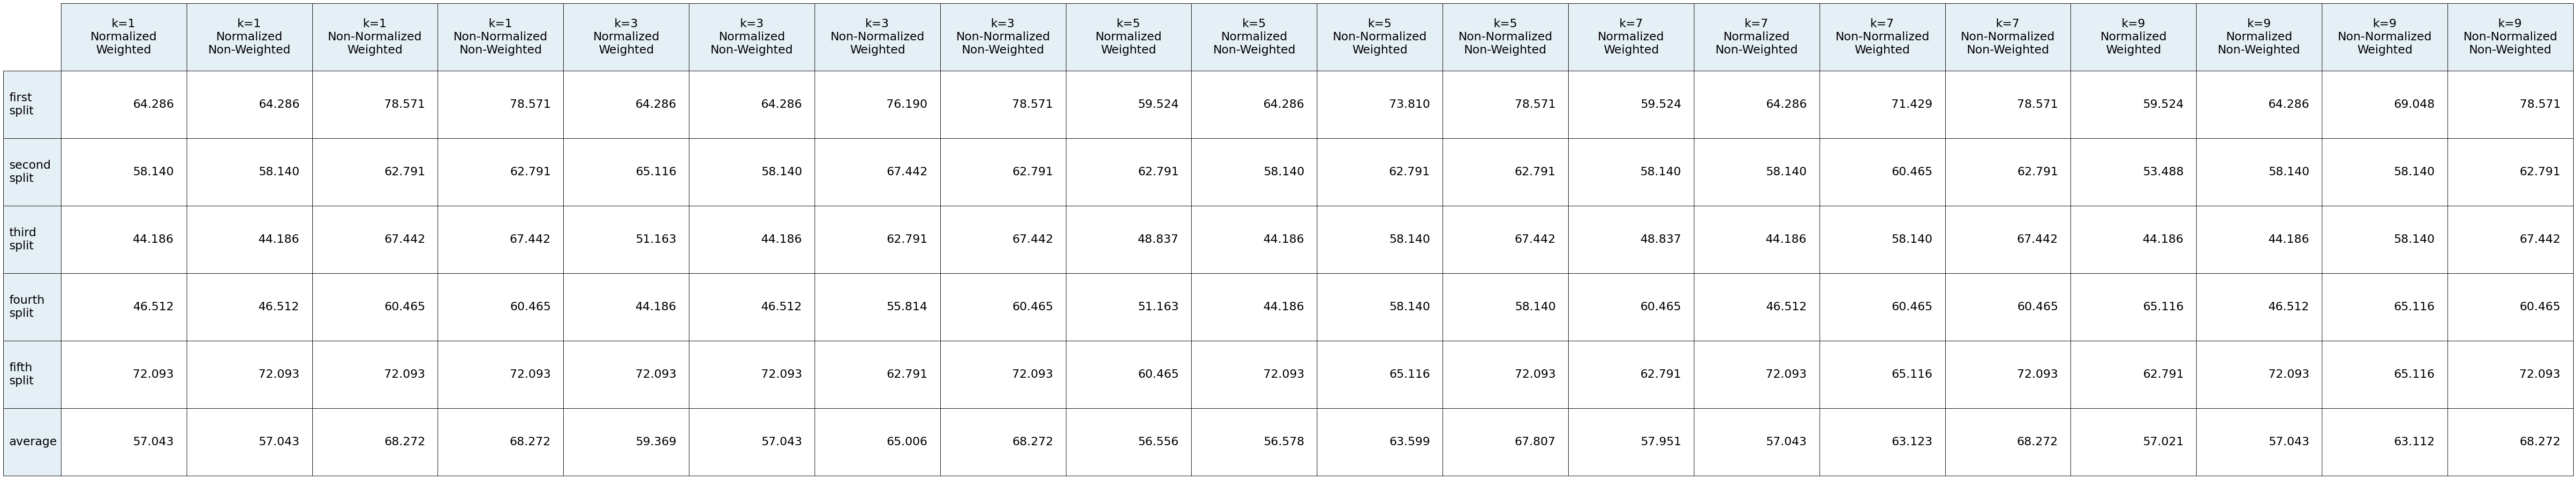

In [24]:
create_table(refined_cls)

# Table For Regression

Drawing table...


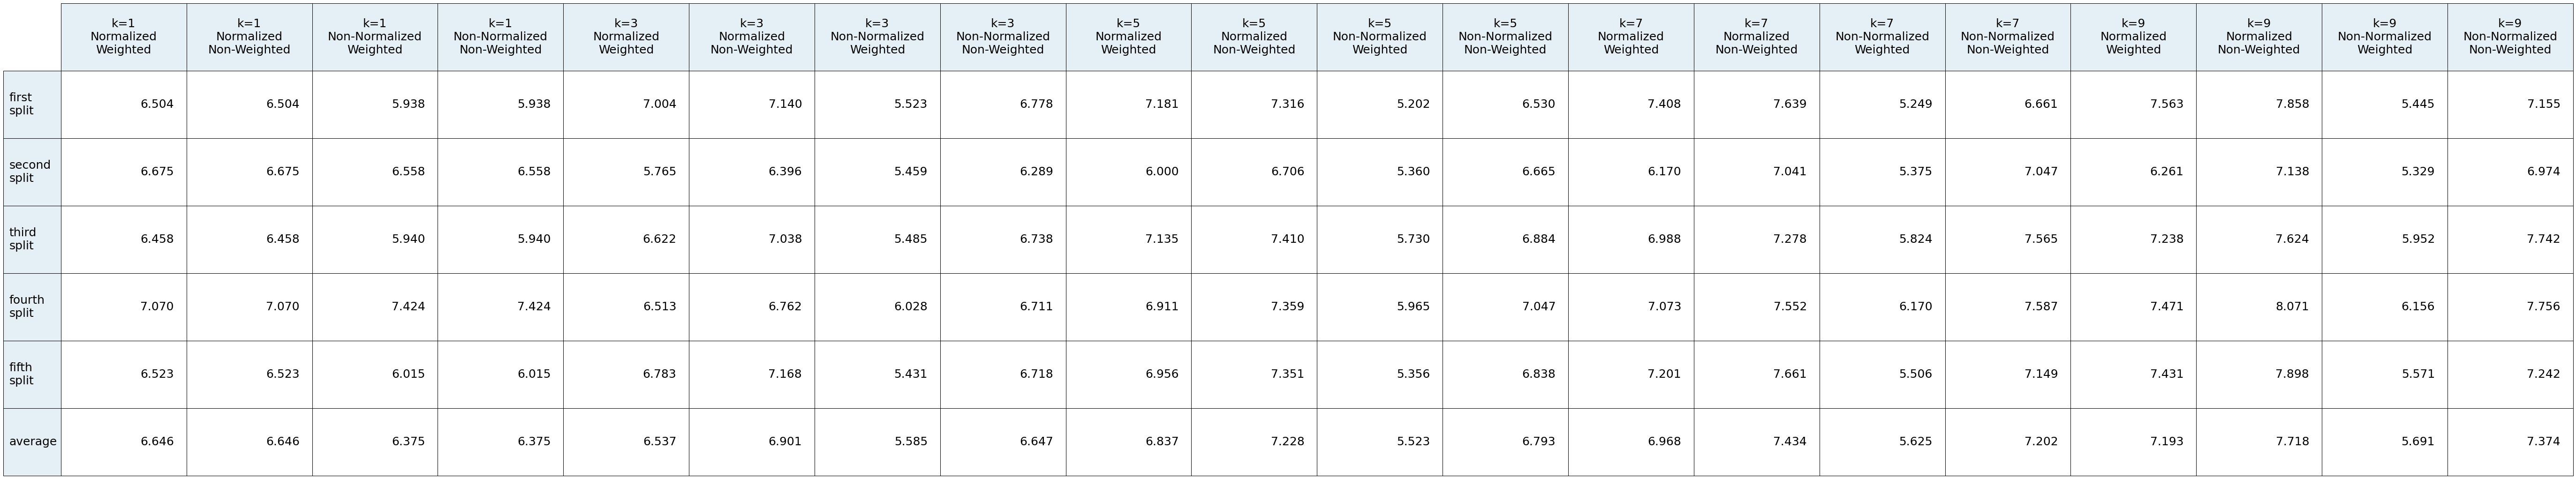

In [25]:
create_table(refined_reg)

### General Information About Choices

- We have chosen shuffling our dataset per each run of our methods.

- We have applied normalizations separately to **train** and **test** sets to avoid data leakage.

- We have decided to give default weight as '1' to duplicate samples on **Weighted-KNN** parts because they have '0' distance which causes *ZeroDivisionError*.

- On the **Classification** parts; for the tie situation, we have summed all tied class distances with each other and sorted again according to sums which helped deciding which class to choose on tie situations.

    - Example: k=5, nearest neighbours: 
       
       -> initial_situation: 
       
       [ 
            [class=1, dist=0.2], 
            [class=3, dist=0.3], 
            [class=3, dist=0.4], 
            [class=1, dist=0.6], 
            [class=5, dist=1.2]
       ]
       
       
       
       -> after tie breaking operation:
       
       [
           [class=3, dist_sum=0.7],
           [class=1, dist_sum=0.8]
           
       ]
       
       -> class 3 chosen in this case.

## Error Analysis For Classification

- In many tests we have done during development, we have seen that accuracy for 5 different train-test has high variance. This is probably because lack of data. This dataset includes 214 sample together with 7 classes, this amount of data most probably not enough for making classification predictions on 7 classed data. 

- Also we have imbalanced data situation which has data with class 1,2 and 3 mostly. In this case, train-test split becomes crucial on model performance and we may not control that as we desire. Model may never see class 7(very rare in dataset) but try to predict class of a sample(no 7 in train but in test). Naturally, this results with false prediction. In this case increasing amount of data while trying to balance it probably helps more than trying to apply balanced split on many ways.

- On the other hand increasing k value not helping as expected because we have limited amount of data again.

- The reason why normalization decreases accuracy is because most of the samples are very close to each other on majority of columns. Scaling between 0-1 makes them look like exactly same for many cases which decreases accuracy.

- On the other hand, considering weights helps model to distinguish two very similar samples from each other on normalized situation which increase accuracy on normalized data. But if we use weigths for non-normalized data, it may decrease accuracy slightly (and it did for many cases) because for tie situations, algorithm may struggle on tie breaking part.    


## Error Analysis For Regression

- For this data, we can say that it is more balanced than **glass data** which makes **mae** values close to each other for many cases on different train-test splits.

- Also because this dataset is a regression dataset, imbalanced problem does not affect as much as classification.

- As specified in classification part, normalization increases **mae** which means it has negative effect on model performance again. Probably because it makes samples become close to each other.

- On the other hand using weighted average increases model performance and decreases **mae** probably because we are calculating average and making closer sample has more effect on average(prediction) is a good idea.

- Using weighted average for prediction, **mae** values decrease both for normalized and non-normalized data which increases model performance.

- For different k values, higher k value affect model performance negatively after some k value as we expected. Since we take a weighted or normal average, the more neighbors we look at, the greater our error will be because each neighbor has a share in the result. On the other hand, error for weighted models increase with smaller slope than non-weighted because closer neighbours have more effect on result but again all neighbours have effect so it increases. In this experiment, k=3 is best k value for regression, **mae** increases on both ways other than k=3.